# Run Perception

AVstack leverages `MMDetection` as its perception engine. With dozens of models across camera and LiDAR tasks, MMDetection can really accelerate the process of AV algorithm development.

In [1]:
import os
import avstack
import avapi

%load_ext autoreload
%autoreload 2

data_base = '../../lib-avstack-api/data/'
obj_data_dir_k = os.path.join(data_base, 'KITTI/object')
raw_data_dir_k = os.path.join(data_base, 'KITTI/raw')
data_dir_n     = os.path.join(data_base, 'nuScenes')

KSM = avapi.kitti.KittiScenesManager(obj_data_dir_k, raw_data_dir_k, convert_raw=False)
NSM = avapi.nuscenes.nuScenesManager(data_dir_n)

KDM = KSM.get_scene_dataset_by_name(scene_name="2011_09_26_drive_0005_sync")
NDM = NSM.get_scene_dataset_by_index(scene_idx=3)

DM = KDM  # let's use KITTI for this one

deallocate_models = True

Cannot import rss library
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
frame = 120
img = DM.get_image(frame, sensor='main_camera')
pc = DM.get_lidar(frame, sensor='main_lidar')
objects_lidar = DM.get_objects(frame, sensor='main_lidar')
objects_camera = DM.get_objects(frame, sensor='main_camera')

## 3D Detection

### Inference

In [16]:
# lidar-based 3D detection
M_lidar_3d = avstack.modules.perception.object3d.MMDetObjectDetector3D(
    model='pointpillars', dataset='kitti', front_only=False, gpu=0, threshold=0.7)
objs_det_lid = M_lidar_3d(pc, frame=frame, identifier='lidar-detection')

Overriding default threshold of 0.5 with 0.7
Loads checkpoint by local backend from path: /home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection3d/checkpoints/kitti/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class_20220301_150306-37dc2420.pth


/home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection3d/mmdet3d/models/dense_heads/anchor3d_head.py:92: UserWarning: dir_offset and dir_limit_offset will be depressed and be incorporated into box coder in the future
  warnings.warn(


### Visualization

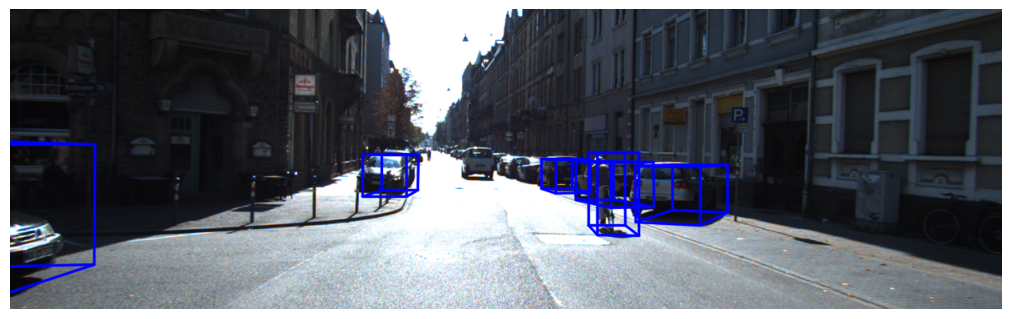

In [4]:
avapi.visualize.snapshot.show_image_with_boxes(img, objs_det_lid, box_colors='blue', inline=True)

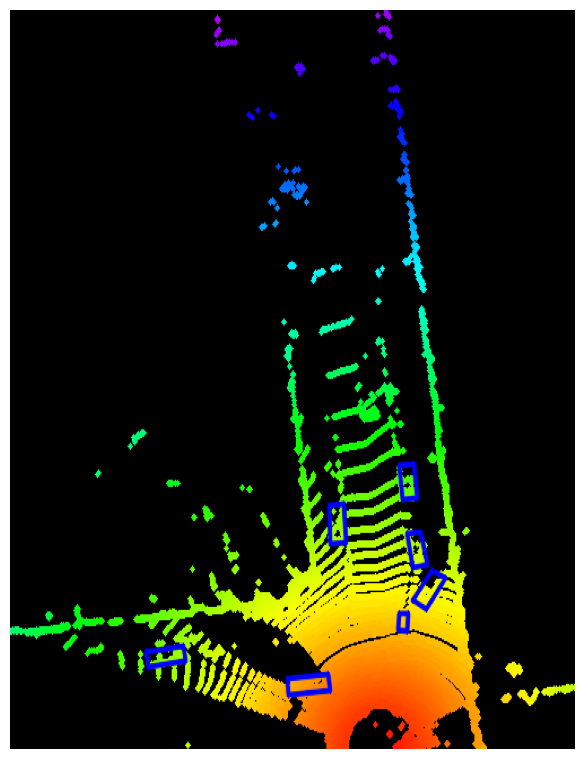

In [5]:
avapi.visualize.snapshot.show_lidar_bev_with_boxes(pc, boxes=objs_det_lid, box_colors='blue')

### Evaluation

In [6]:
# In this case, the "false positives" are just because KITTI
# doesn't label everything in the scene. The perception is solid.
avapi.evaluation.ResultManager(idx=frame,
    detections=objs_det_lid, truths=objects_lidar, metric='3D_IoU')

Result Manager
----7 detections, 5 truths
----0 detections are dontcares
----5 Assignments, 2 FPs, 0 FNs

## 2D Detection

### Inference

In [7]:
# camera-based 2D detection
M_camera_2d = avstack.modules.perception.object2dfv.MMDetObjectDetector2D(
    model='fasterrcnn', dataset='kitti', front_only=True, gpu=0, threshold=0.7)
objs_det_cam = M_camera_2d(img, frame=frame, identifier='camera-detection')

Overriding default threshold of 0.5 with 0.7
Loads checkpoint by local backend from path: /home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection/checkpoints/cityscapes/faster_rcnn_r50_fpn_1x_cityscapes_20200502-829424c0.pth


### Visualization

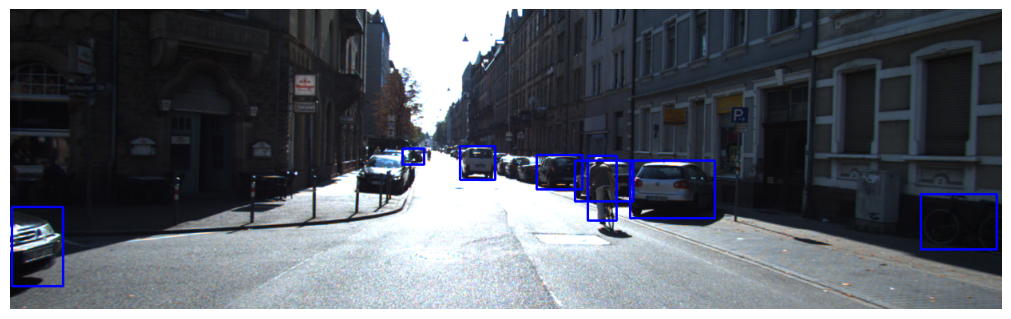

In [8]:
avapi.visualize.snapshot.show_image_with_boxes(img, objs_det_cam, box_colors='blue', inline=True)

### Evaluation

In [9]:
# Again, the "false positives" are just because KITTI
# doesn't label everything in the scene. The perception is solid.
avapi.evaluation.ResultManager(idx=frame,
    detections=objs_det_cam, truths=objects_camera, metric='2D_IoU')

Result Manager
----8 detections, 5 truths
----0 detections are dontcares
----5 Assignments, 3 FPs, 0 FNs

## Monocular Detection

### Inference

In [13]:
# camera-based 3D detection
M_camera_3d = avstack.modules.perception.object3d.MMDetObjectDetector3D(
    model='pgd', dataset='kitti', front_only=True, gpu=0, threshold=5)
objs_det_cam3d = M_camera_3d(img, frame=frame ,identifier='camera-detection')

Overriding default threshold of 5 with 5
Loads checkpoint by local backend from path: /home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection3d/checkpoints/kitti/pgd_r101_caffe_fpn_gn-head_3x4_4x_kitti-mono3d_20211022_102608-8a97533b.pth
05/11 13:37:54 - mmengine - INFO - ModulatedDeformConvPack bbox_head.cls_convs.1.conv is upgraded to version 2.
05/11 13:37:54 - mmengine - INFO - ModulatedDeformConvPack bbox_head.reg_convs.1.conv is upgraded to version 2.


### Visualization

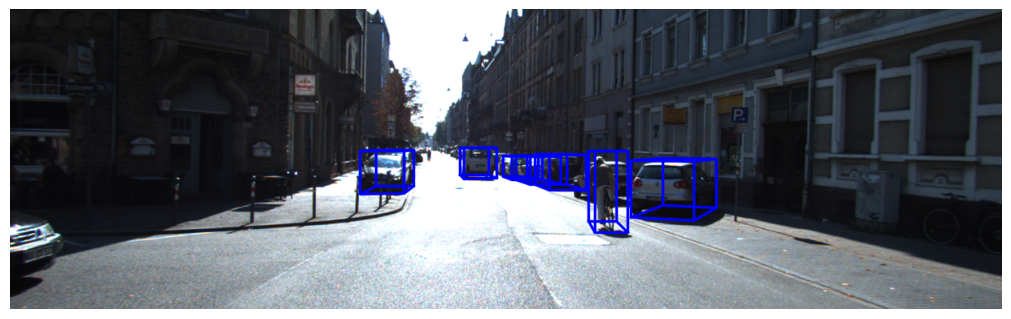

In [14]:
avapi.visualize.snapshot.show_image_with_boxes(img, objs_det_cam3d, box_colors='blue', inline=True)

### Evaluation

In [15]:
# Again, the "false positives" are just because KITTI
# doesn't label everything in the scene.
avapi.evaluation.ResultManager(idx=frame,
    detections=objs_det_cam3d, truths=objects_lidar, metric='3D_IoU')

Result Manager
----7 detections, 5 truths
----0 detections are dontcares
----3 Assignments, 4 FPs, 2 FNs